In [31]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

data = pd.read_csv('yelp_labelled.txt', delimiter='\t', header=None)
data.columns = ['text', 'label']

print(data.head())

                                                text  label
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1


In [89]:
#External preproccessing
import re

def preprocess_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'[^\w\s]', ' ', text) # Remove punctuation
    text = re.sub(r'\(.*?\)', ' ', text) # remove parentheses
    return text

data['preprocessed'] = data['text'].apply(preprocess_text)
print("Preprocessed text sample:", data['preprocessed'].iloc[0])

X = data['preprocessed']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')

Preprocessed text sample: wow    loved this place 
Training samples: 800, Testing samples: 200


In [90]:
# Baseline Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('classifier', LogisticRegression(max_iter=1000))
])

baseline_mean = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted').mean()
print(f'Baseline F1 scores: {baseline_mean}')

Baseline F1 scores: 0.7956374342958608


In [93]:
# Internal preproccessing
from sklearn.base import BaseEstimator, TransformerMixin

def negation_handling(text):
    # Simple negation handling: append '_NEG' to words following a negation word
    negation_words = {"not", "no", "never", "n't"}
    tokens = text.split()
    result = []
    negate = False
    for token in tokens:
        if token in negation_words:
            negate = True
            result.append(token)
        elif negate:
            result.append(token + '_NEG')
            negate = False
        else:
            result.append(token)
    return ' '.join(result)

class TextPreprocessor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        result = []
        for text in X:
            text = text.lower() # Lowercase
            text = re.sub(r'\s+', ' ', text).strip() # standardize spaces
            text = negation_handling(text) # Negation handling
            result.append(text)
        return result

In [ ]:
# define pipeline with internal preprocessing   
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV



models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'NB': MultinomialNB(),
    'SVM': SVC()
}

param_grids = {
    'Logistic Regression': [
        # Logistic Regression with CountVectorizer and TfidfVectorizer
        {
                'vectorizer': [CountVectorizer()],
                'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
                'vectorizer__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\b\w+\b', r'\S+'],
                'vectorizer__max_df': [0.8, 0.9, 1.0],
                'vectorizer__min_df': [1, 2],
                'vectorizer__stop_words': [None, 'english'],
                'classifier__C': [0.1, 1.0, 10.0]
        },
        {
                'vectorizer': [TfidfVectorizer()],
                'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
                'vectorizer__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\b\w+\b', r'\S+'],
                'vectorizer__max_df': [0.8, 0.9, 1.0],
                'vectorizer__min_df': [1, 2],
                'vectorizer__stop_words': [None, 'english'],
                'classifier__C': [0.1, 1.0, 10.0]
        }
    ],
    'NB': [
        # Naive Bayes with CountVectorizer and TfidfVectorizer
        {
                'vectorizer': [CountVectorizer()],
                'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
                'vectorizer__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\b\w+\b', r'\S+'],
                'vectorizer__max_df': [0.8, 0.9, 1.0],
                'vectorizer__min_df': [1, 2],
                'vectorizer__stop_words': [None, 'english'],
                'classifier__alpha': [0.1, 1.0, 10.0]
        },
        {
                'vectorizer': [TfidfVectorizer()],
                'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
                'vectorizer__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\b\w+\b', r'\S+'],
                'vectorizer__max_df': [0.8, 0.9, 1.0],
                'vectorizer__min_df': [1, 2],
                'vectorizer__stop_words': [None, 'english'],
                'classifier__alpha': [0.1, 1.0, 10.0]
        }   
    ],
    'SVM': [
        {
        # SVM with CountVectorizer
        'vectorizer': [CountVectorizer()],
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'vectorizer__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\b\w+\b', r'\S+'],
        'vectorizer__max_df': [0.8, 0.9, 1.0],
        'vectorizer__min_df': [1, 2],
        'vectorizer__stop_words': [None, 'english'],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        # SVM with TfidfVectorizer
        'vectorizer': [TfidfVectorizer()],
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
                'vectorizer__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\b\w+\b', r'\S+'],
        'vectorizer__max_df': [0.8, 0.9, 1.0],
        'vectorizer__min_df': [1, 2],
        'vectorizer__stop_words': [None, 'english'],
        'classifier__C': [0.1, 1.0, 10.0], 
        'classifier__kernel': ['linear', 'rbf']
    }
    ]
}

best_models = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', TextPreprocessor()), # internal preprocessing
        ('vectorizer', CountVectorizer(stop_words='english')), # will be replaced in GridSearch
        ('classifier', model)
    ])

    grid_search = GridSearchCV(
            pipeline, 
            param_grids[model_name], 
            cv=5, 
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )
    
    grid_search.fit(X_train, y_train)
    best_models[model_name] = {
            'model': grid_search.best_estimator_,
            'score': grid_search.best_score_,
            'params': grid_search.best_params_
        }
    
    print(f'Best {model_name} F1 Score: {grid_search.best_score_}')
    print(f'Best {model_name} Parameters: {grid_search.best_params_}')  



Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Logistic Regression F1 Score: 0.8261105761263551
Best Logistic Regression Parameters: {'classifier__C': 10.0, 'vectorizer': TfidfVectorizer(), 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b'}
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best NB F1 Score: 0.8136371677789989
Best NB Parameters: {'classifier__alpha': 1.0, 'vectorizer': TfidfVectorizer(), 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b'}
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best SVM F1 Score: 0.8273826988413993
Best SVM Parameters: {'classifier__C': 10.0, 'classifier__kernel': 'rbf', 'vectorizer': TfidfVectorizer(), 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 1, 'vector

In [95]:
#Select Final model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("\nBest Model Selection Based on Cross-Validation F1 Scores:")

final_model = max(best_models.items(), key=lambda x: x[1]['score'])
print(f'Selected Model: {final_model[0]} with F1 Score: {final_model[1]["score"]}')
final_model_instance = final_model[1]['model']

print(f"Improvement over baseline: {best_models[final_model[0]]['score'] - baseline_mean:.3f}")

print(f"\nDetailed Evaluation of {final_model[0]}:")
y_pred = final_model_instance.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")

print(f"Classification Report for {final_model[0]}:\n")
print(classification_report(y_test, y_pred))


Best Model Selection Based on Cross-Validation F1 Scores:
Selected Model: SVM with F1 Score: 0.8273826988413993
Improvement over baseline: 0.032

Detailed Evaluation of SVM:
Test Accuracy: 0.830
Test F1 Score: 0.830
Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        96
           1       0.86      0.80      0.83       104

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



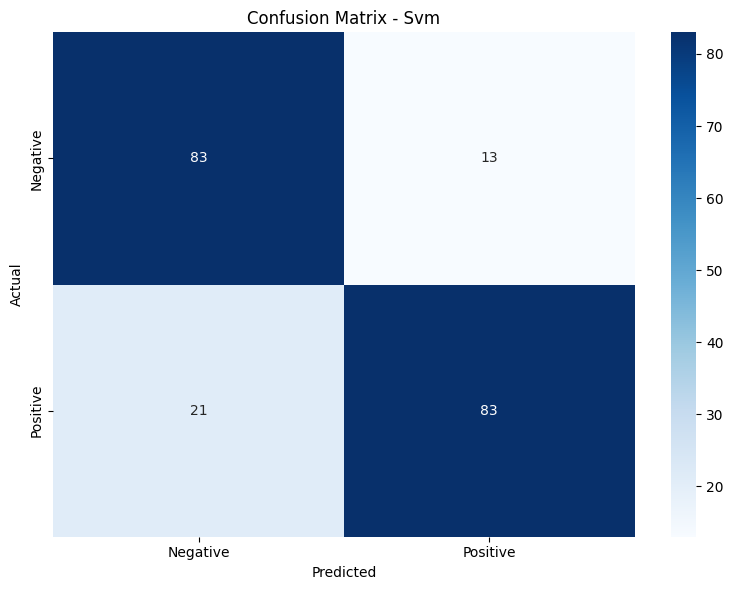

In [96]:
#visualization 1
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {final_model[0].title()}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

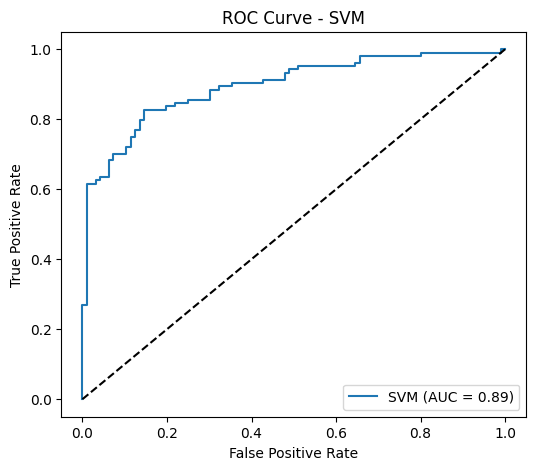

In [ ]:
#visualization 2
from sklearn.metrics import roc_curve, auc

y_scores = final_model_instance.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()

In [105]:
print("\nCreating sample CSV file...")

# select 5 pos and neg reviews from dataset
positive_view = data[data['label'] == 1].sample(5, random_state=42)
negative_view = data[data['label'] == 0].sample(5, random_state=42)
sample_df = pd.concat([positive_view, negative_view]).reset_index(drop=True)

# get original and outside processed text
original_texts = sample_df['text'].values
preprocessed_texts = sample_df['preprocessed'].values   

final_texts = final_model_instance.named_steps['preprocessor'].transform(preprocessed_texts)

# Create output CSV
output_data = {
    'original_review': original_texts,
    'after_external_preprocessing': preprocessed_texts,
    'after_pipeline_preprocessing': final_texts
}

output_df = pd.DataFrame(output_data)
output_df.to_csv('preprocessing_examples.csv', index=False)
print("Sample CSV saved as 'preprocessing_examples.csv'")



Creating sample CSV file...
Sample CSV saved as 'preprocessing_examples.csv'
